In [1]:
import sys
sys.path.append("../../../")

## 数据

In [2]:
from pylib.utils.functions_for_regression import nonlin_data, plot_scatter
import matplotlib.pyplot as plt

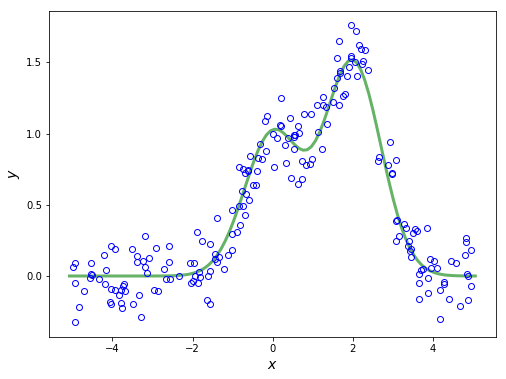

In [3]:
X_train, y_train, X_test, y_test, f_truth = nonlin_data(300)
plt.figure(figsize=(8, 6))
plot_scatter(X_train, y_train, f=f_truth)
plt.show()

## 核岭回归

### 使用正规方程求解

In [4]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel,linear_kernel
from pylib.utils.functions_for_regression import plot_fitted_line
import numpy as np

In [5]:
class KernelRidgeRegression(BaseEstimator, RegressorMixin):
    """
    核岭回归
    参数：
    -----
    kernel: 
    lamb: L2正则化强度
    
    属性：
    -----
    K: 核矩阵
    alpha: 对偶系数
    """
    kernel_dict = None
    
    def __linear_kernel(self, X, Y):
        return X @ Y.T
    
    def __polynomial_kernel(self, X, Y, coef, degree):
        return (X @ Y.T + coef)**degree
    
    def __rbf_kernel(self, X, Y, gamma=None):
        if gamma is None:
            gamma = 1.0 / X.shape[1]
        n = len(X)
        m = len(Y)
        K = np.zeros((n, m))
        for i in range(n):
            for j in range(m):
                d = np.sqrt(np.sum((X[i] - Y.T[:,j])**2))
                K[i][j] = np.exp(-gamma * d)
        return K
    
    def __init__(self, kernel, lamb=1):
        self.kernel = kernel
        self.lamb = lamb
    
    def fit(self, X, y):
        
        KernelRidgeRegression.kernel_dict = {"linear": self.__linear_kernel,
                                             "polynomial": self.__polynomial_kernel,
                                             "rbf": self.__rbf_kernel}
        self.K = KernelRidgeRegression.kernel_dict[self.kernel](X, X)
        
        n = len(self.K)
        self.alpha = np.linalg.inv(self.K + self.lamb * np.identity(n)) @ y # 正规方程
        self.X_fit_ = X
        return self
    
    def predict(self, X):
        K = KernelRidgeRegression.kernel_dict[self.kernel](X, self.X_fit_)
        y_pred = K @ self.alpha
        return y_pred

In [6]:
# X_train_b = np.c_[np.ones(len(X_train)), X_train]
kernel_reg1 = KernelRidgeRegression(kernel='rbf')
kernel_reg1.fit(X_train, y_train)

KernelRidgeRegression(kernel='rbf')

In [7]:
y_train_preds = kernel_reg1.predict(X_train)
train_err = mean_squared_error(y_train, y_train_preds)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.017


In [8]:
y_test_preds = kernel_reg1.predict(X_test)
test_err = mean_squared_error(y_test, y_test_preds)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.025


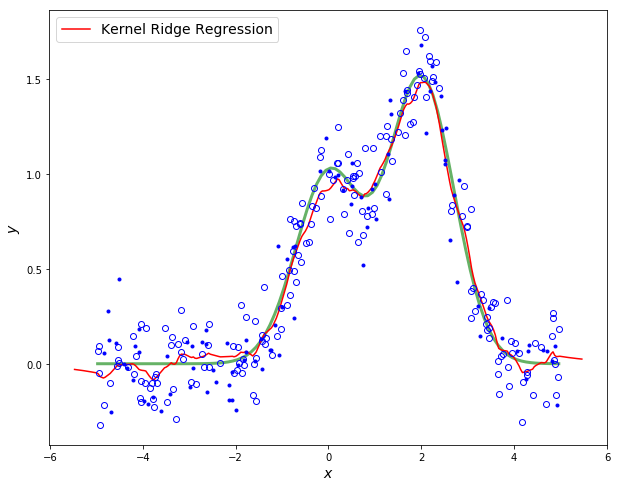

In [9]:
plt.figure(figsize=(10, 8))
plot_scatter(X_train, y_train, X_test, y_test, f=f_truth)
plot_fitted_line(kernel_reg1, "Kernel Ridge Regression")
plt.show()

### 使用奇异值分解求解

In [10]:
class KernelRidgeRegression(BaseEstimator, RegressorMixin):
    """
    核岭回归
    参数：
    -----
    kernel: 
    lamb: L2正则化强度
    
    属性：
    -----
    K: 核矩阵
    alpha: 对偶系数
    
    """
    kernel_dict = None
    
    def __linear_kernel(self, X, Y):
        return X @ Y.T
    
    def __polynomial_kernel(self, X, Y, coef0=1, degree=8):
        return (X @ Y.T + coef0)**degree
    
    def __rbf_kernel(self, X, Y, gamma=None):
        if gamma is None:
            gamma = 1.0 / X.shape[1]
        n = len(X)
        m = len(Y)
        K = np.zeros((n, m))
        for i in range(n):
            for j in range(m):
                d = np.sqrt(np.sum((X[i] - Y.T[:,j])**2))
                K[i][j] = np.exp(-gamma * d)
        return K
    
    def __init__(self, kernel, lamb=1):
        self.kernel = kernel
        self.lamb = lamb
    
    def fit(self, X, y):
        KernelRidgeRegression.kernel_dict = {"linear": self.__linear_kernel,
                                             "polynomial": self.__polynomial_kernel,
                                             "rbf": self.__rbf_kernel}
        self.K = KernelRidgeRegression.kernel_dict[self.kernel](X, X)
        n = len(self.K)
        u, s, vh = np.linalg.svd(self.K + self.lamb * np.identity(n), full_matrices=False) # 奇异值分解
        self.alpha = vh.T @ np.diag(1.0 / s) @ u.T @ y 
        self.X_fit_ = X
        return self
    
    def predict(self, X):
        K = KernelRidgeRegression.kernel_dict[self.kernel](X, self.X_fit_)
        y_pred = K @ self.alpha
        return y_pred

In [11]:
kernel_reg2 = KernelRidgeRegression(kernel='polynomial')
kernel_reg2.fit(X_train, y_train)

KernelRidgeRegression(kernel='polynomial')

In [12]:
y_train_preds = kernel_reg2.predict(X_train)
train_err = mean_squared_error(y_train, y_train_preds)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.037


In [13]:
y_test_preds = kernel_reg2.predict(X_test)
test_err = mean_squared_error(y_test, y_test_preds)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.048


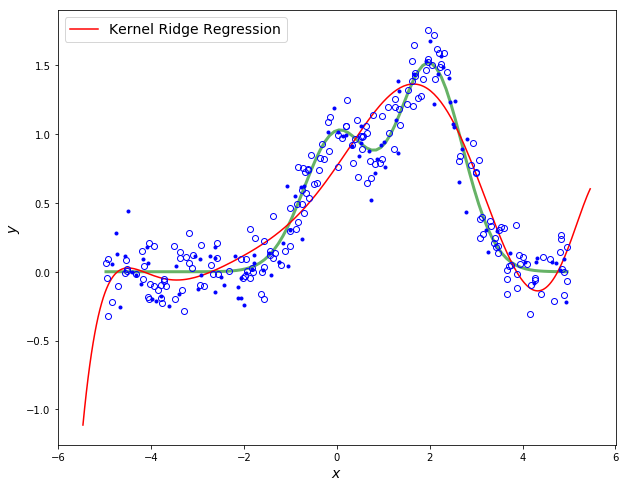

In [14]:
plt.figure(figsize=(10, 8))
plot_scatter(X_train, y_train, X_test, y_test, f=f_truth)
plot_fitted_line(kernel_reg2, "Kernel Ridge Regression")
plt.show()

### 核矩阵分析

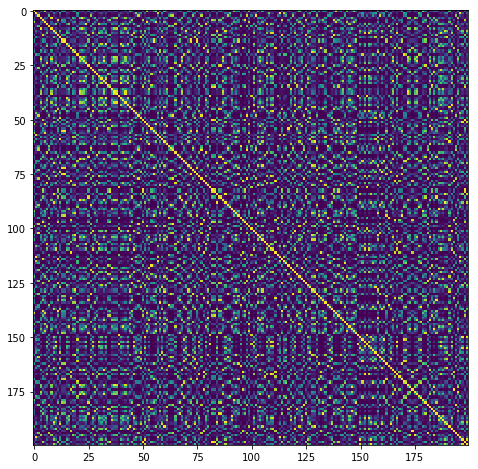

In [15]:
kernel_matrix = kernel_reg1.K
plt.figure(figsize=(8, 8))
plt.imshow(kernel_matrix)
plt.show()

In [16]:
eigen_vals, eigen_vecs = np.linalg.eig(kernel_matrix)
sorted_idx = np.argsort(eigen_vals)[::-1]
eigen_vals = eigen_vals[sorted_idx]
eigen_vecs = eigen_vecs[:, sorted_idx]

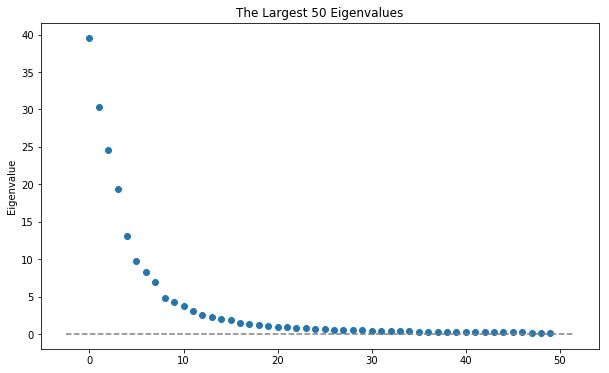

In [17]:
top50 = eigen_vals[:50]

plt.figure(figsize=(10, 6))
plt.scatter(range(50), top50)
plt.hlines(1e-13, plt.xlim()[0], plt.xlim()[1],
           color="gray", linestyles="--")
plt.title("The Largest 50 Eigenvalues")
plt.ylabel("Eigenvalue")
plt.show()

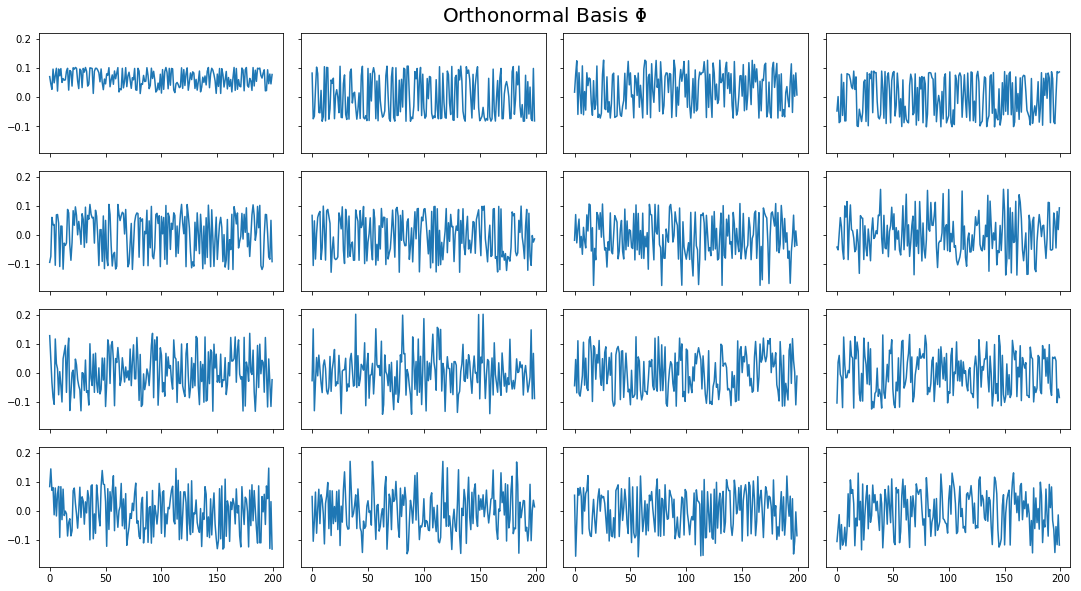

In [18]:
fig, ax = plt.subplots(4, 4, figsize=(15, 8), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(16):
    ax[i].plot(range(len(X_train)), eigen_vecs[:, :50][:, i])
fig.suptitle(r"Orthonormal Basis $\mathtt {\Phi}$", fontsize=20, x=0.5, y=1.02)
plt.tight_layout()
plt.show()

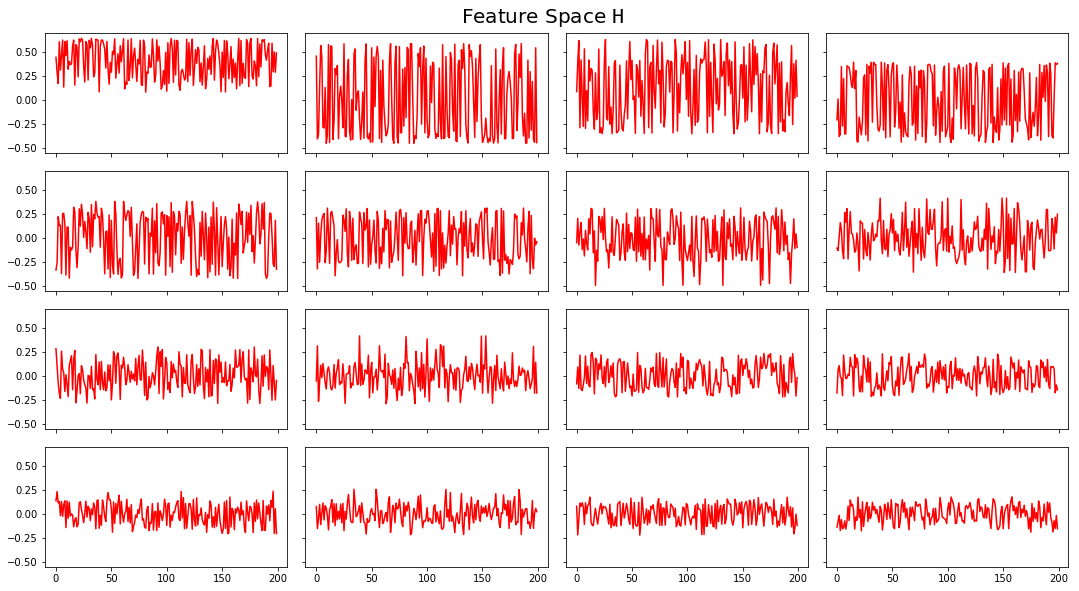

In [19]:
fig, ax = plt.subplots(4, 4, figsize=(15, 8), sharex=True, sharey=True)
ax = ax.flatten()
for i in range(16):
    ax[i].plot(range(len(X_train)), np.sqrt(eigen_vals[i]) * eigen_vecs[:, :50][:, i], 'r')
fig.suptitle(r"Feature Space $\mathtt {H}$", fontsize=20, x=0.5, y=1.02)
plt.tight_layout()
plt.show()